## Project 1d: Evolution of antibiotic resistance
### Mimi Filova | Statistical Biophysics | Summer 2023

Use the experimentally determined fitness landscapes from <a href="https://www.science.org/doi/abs/10.1126/science.1123539">Weinrich et al (2006)</a> to simulate the evolution of antibiotic resistance and to study pathways of evolution on that landscape. <br> N.B. Here fitness is not given by the growth rate directly

### Summary of <a href="https://www.science.org/doi/abs/10.1126/science.1123539">Weinrich et al (2006)</a> 

* experimental paper, looks at mutations of a gene [the $\beta$-lactamase allele] in bacteria [type]
* $\beta$-lactamase governs how bacteria responds to the presence of an ($\beta$-lactame) antibiotic
* antibiotic-resistant vs wild type comparison yields: 5 point (SNP) mutations on the gene of interest
* with all 5 mutations, bacterias are resistant to antibiotics about 10^5 times more
* note: antibiotics either kill or stop growth of bacteria

### mutations & pathways
summary: 5 mutation points; 32 combinations of mutations; 120 pathways for them to emerge.
* 5 point mutations, with each having 2 options
* total of 2^5 = 32 sequences possible
* mutating one by one, 5 * 4 * 3 *... = 5! = 120 ways to get to final mutation
* strong selection / slow mutation model 




In [323]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math as m

### experiment (MIC for each combo)
* prepared a sample for each of the 32 combinations
* for each sample, varied the concentration of antibiotic
* found the MIC - minimum inhibitory concentration, at which cell number stops growing
* experiment is done s.t. in petri dish we can only measure N of cells

In [324]:
# constants

# data from paper

# experimentally measured, order is as given in paper by binary 00001 etc order
MIC = np.array(
    [0.088, 0.088, 1.4, 1.4, 0.063, 0.088, 32, 360,
     0.13, 0.18, 360, 360, 0.18, 0.18, 360, 2100,
     0.088, 0.088, 23, 360, 1.4, 0.088, 360, 360,
     1.4, 2.0, 2100, 1500, 0.80, 1.4, 2900, 4100]
)

#32 mutations combos code
mutations_32  = [ '00000','00001','00010','00011','00100','00101','00110','00111',
                  '01000','01001','01010','01011','01100','01101','01110','01111',
                  '10000','10001','10010','10011','10100','10101','10110','10111',
                  '11000','11001','11010','11011','11100','11101','11110','11111']

#mutation names, order as in binary code
mutations_code = ['A42G','E104K','M182T','G238S','g4205a']

# parameters

# growth rates at no antibiotic
g0 = np.array([1.]*len(MIC))
# don't want all combos to be equally growing at ant = 0? change g0 here

### Info
* antibiotic: cefotaxime, third-generation cephalosporin B-lactam
* gene TEM^wt vs evolved, antibiotic resistant gene TEM* with 5 mutations
* 4 missense mutations at clinically relevant residues (A42G, E104K, M182T, G238S)
* 1 noncoding mutation (g4205a)

In [325]:
# functions

# growth rate generate

def f_growth(c_loc=None,MIC_loc=None, g0_loc=None):
    # growth rate (antibiotic concentration)
    # don't want linear growth rate? change this return eqn
    return -1/MIC_loc*c_loc+g0_loc

def get_mu(mu=None):
    # no death
    for i in range(0,len(mu)):
        if mu[i] < 0: mu[i] = 0
    return mu

### Visualize data

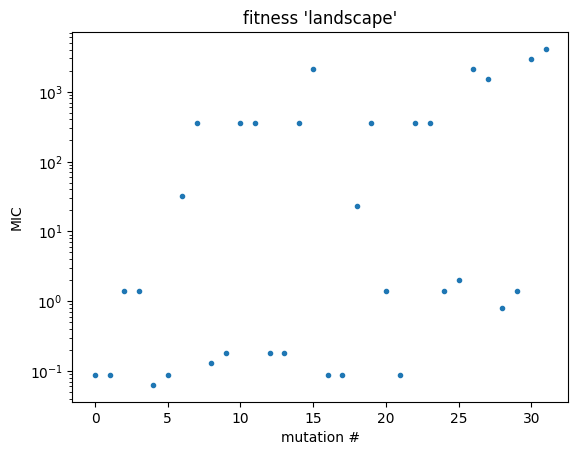

In [327]:
# annotator function that draws a label and an arrow 
# that points from the label to its corresponding point
def annotate(ax, label, x, y, xytext):
    ax.annotate(label, xy=(x,y), 
                xytext=xytext, textcoords='offset points', 
                fontsize=6, 
                arrowprops={'arrowstyle': '-|>', 'color': 'black'})

# sanity checks & all
xx = np.arange(len(MIC))

fig, ax = plt.subplots()
ax.plot(xx,MIC,'.')

# conditionally position labels
"""
for label, x, y in zip(mutations_32, xx, MIC):
    if x%2==0:
        annotate(ax, label, x, y, (-10, 20))
    else:
        annotate(ax, label, x, y, (10, -20))
    arrowprops=dict(facecolor='black', shrink=0.001)
"""
ax.set_xlabel('mutation #')
ax.set_ylabel('MIC')
ax.set_title("fitness \'landscape'")

ax.set_yscale('log')
#fig.savefig("fitness_no-annot.jpg",dpi=300)

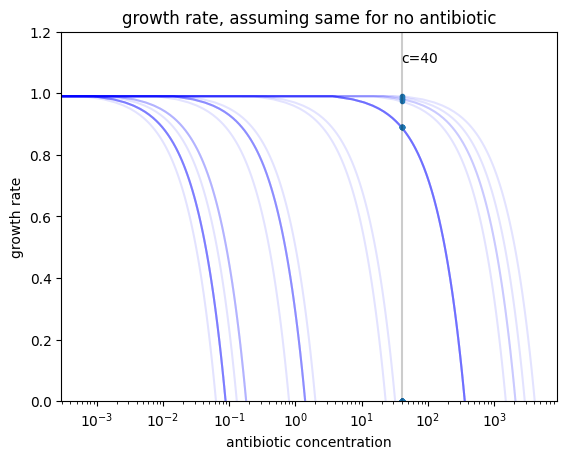

In [328]:
# visualize growth rate

i=1
# plot growth rate (concentration)
for m,g in zip(MIC,g0):
    # for each sequence combo
    c = np.linspace(0,m,100)
    plt.plot(c,f_growth(c,m,g),c='blue',alpha=0.1+i/32*0.3)
    #i+=1 # for line colors

plt.xlabel('antibiotic concentration')
plt.ylabel('growth rate')
plt.ylim(0,1.2)
plt.title('growth rate, assuming same for no antibiotic')
plt.xscale('log')

# fixed c; what are the growth rates?
c = 40
mu = get_mu(f_growth(c,MIC,g0))
# mu is growth rates for each mutation at antibiotic conc c

plt.plot([c]*len(MIC),mu,'.')
#plt.xlim(0,c+10)
plt.vlines(c,0,1.2,'k',alpha=0.2)
plt.text(c,1.1,'c='+str(c))
#plt.savefig("growth-lin-new.jpg",dpi=300)
plt.show()


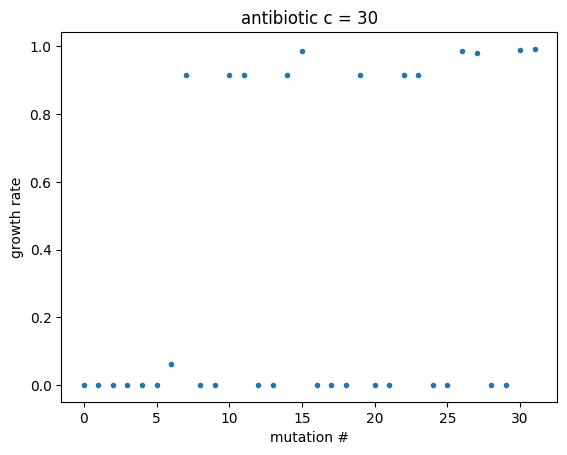

In [330]:
c = 30
mu = get_mu(f_growth(c,MIC,g0))
plt.plot(mu,'.')
plt.xlabel('mutation #')
plt.ylabel('growth rate')
plt.title('antibiotic c = 30')
#plt.savefig('g-rates-at-c.jpg',dpi=300)

### Diff Eqn for growth + selection

2 species <br>
$\dot{n_a} = \mu_a n_a$ <br>
$\dot{n_b} = \mu_b n_b$ <br>
<br> fractions <br>
$f_{a,b} = \frac{n_{a,b}}{n_a+n_b}$ <br>
$1-f_a=f_b; \dot{f_a}=-\dot{f_b}$ <br>
$ \dot{f_a} = (\mu_a-\mu_b)f_a f_b$ <br>
<br>final <br>
$ \bar{\mu} = \mu_a f_a + \mu_b f_b$ <br>
$\dot{f_a} = f_a(\mu_a - \bar{\mu})$

[0.         0.         0.         0.         0.         0.
 0.         0.88888889 0.         0.         0.88888889 0.88888889
 0.         0.         0.88888889 0.98095238 0.         0.
 0.         0.88888889 0.         0.         0.88888889 0.88888889
 0.         0.         0.98095238 0.97333333 0.         0.
 0.9862069  0.9902439 ]


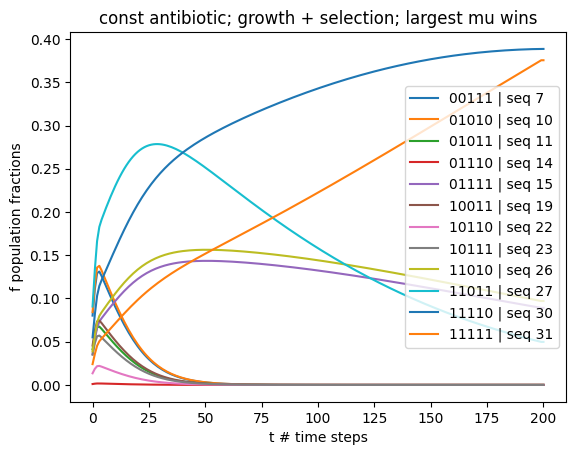

In [332]:
c = 40 # antibiotic conc
mu = get_mu(f_growth(c,MIC,g0)) # for all species
print(mu)

f = np.random.rand(len(mu)) #rand initial population
f=f/np.sum(f)

# time steps 
dt = 1
ff =[f]
for i in range(0,200):
    mu_w = np.sum(f*mu) #avg mu
    for j in range(0,len(f)):
        # for each species
        f[j]+=(mu[j]-mu_w)*f[j]*dt
    f = f/np.sum(f)
    ff.append(f)
        
evol = np.array(ff).T

for count,traj in enumerate(evol):
    if mu[count]>0.3:
        #plt.plot(traj,'-',c='blue',alpha=0.4*mu[count],ms=3,label=mutations_32[count])
        plt.plot(traj,'-',ms=3,label=mutations_32[count]+" | seq "+str(int(mutations_32[count],2)))

plt.xlabel("t # time steps")
plt.ylabel("f population fractions")
plt.title("const antibiotic; growth + selection; largest mu wins")
plt.legend()
#plt.savefig('const-ant-sel.jpg',dpi=300)

### growth and selection at changing [antibiotic]

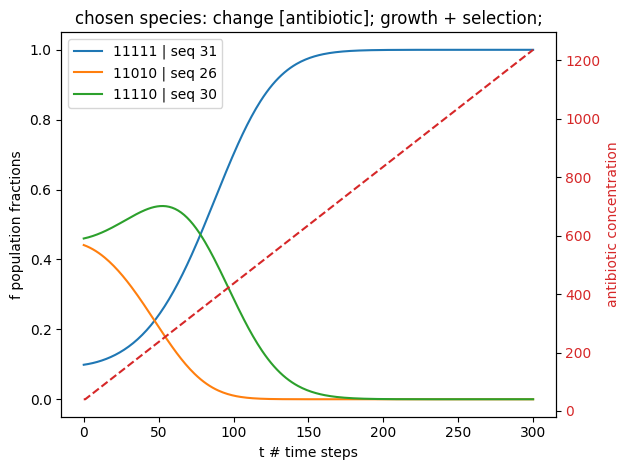

In [337]:
# sequences 31, 26, 30

c_init = 40 # antibiotic conc
seq = [31,26,30]

mu = get_mu(f_growth(c_init,MIC[seq],g0[seq])) # for chosen seq species

f = np.random.rand(len(mu)) #rand initial population
f=f/np.sum(f)

# time steps 
dt = 1
ff =[f]
cc=[c_init]
for i in range(0,300):
    c_t = c_init*i/10+c_init
    mu = get_mu(f_growth(c_t,MIC[seq],g0[seq]))
    
    mu_w = np.sum(f*mu) #avg mu
    
    for j in range(0,len(f)):
        # for each species
        f[j]+=(mu[j]-mu_w)*f[j]*dt
    f = f/np.sum(f)
    ff.append(f)
    cc.append(c_t)
        
evol = np.array(ff).T

# plotting
fig, ax1 = plt.subplots()

for count,traj in enumerate(evol):
    if mu[count]>0.3:
        #plt.plot(traj,'-',c='blue',alpha=0.4*mu[count],ms=3,label=mutations_32[count])
        ax1.plot(traj,'-',ms=3,label= str(bin(seq[count]))[2:]+" | seq "+str(seq[count]))

ax1.set_xlabel("t # time steps")
ax1.set_ylabel("f population fractions")
ax1.set_title("chosen species: change [antibiotic]; growth + selection;")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(cc,'--',c=color)
ax2.set_ylabel('antibiotic concentration',c=color)
fig.tight_layout()
#fig.savefig('3species-change-antibiot.jpg',dpi=300)

# eqns with N not f?

### Diff eqn for growth, mutation and selection

In [161]:

# mutation q matrix

Q = np.zeros((len(MIC),len(MIC)))
for i in range(0,len(MIC)):
    # for each row i
    for j in range(0,len(MIC)):
        # for pair i,j where i>j
        if i !=j and m.log2(i ^ j)%1==0.0:
            # if (i XOR j binary) is a power of 2
            # then i and j are 1 mutation away
            # a.k.a. checks that hamming distance = 1
            
            Q[i][j] = 0.01 # probability of mutation at one location
            
    Q[i][i] = 0.95 # probability of no mutation



### Simple mutation from wt

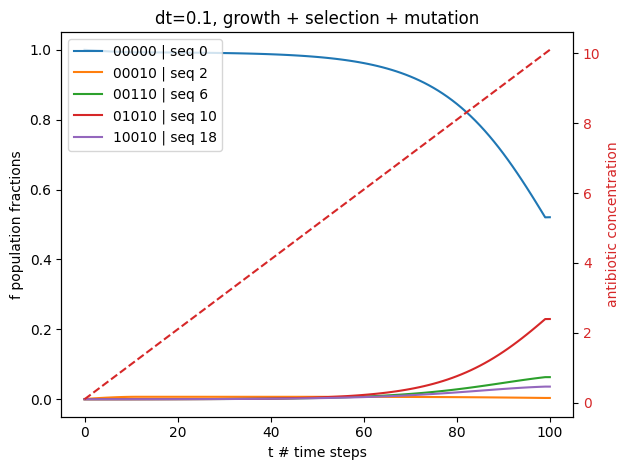

In [349]:
# mutation, growth, selection
c_init = 0.1 # const 

seq = np.arange(len(MIC))

mu = get_mu(f_growth(c_init,MIC[seq],g0[seq])) # eqns for all possible species

f = np.zeros(len(mu)) #start with wildtype only
f[0]=1

f=f/np.sum(f)

# time steps 
dt = 0.1
ff =[f]
cc=[c_init]
c_t = c_init
for i in range(0,100):
    c_t += c_init
    mu = get_mu(f_growth(c_t,MIC[seq],g0[seq]))
    
    mu_w = np.sum(f*mu) #avg mu
    
    for j in range(0,len(f)):
        # for each species
        f[j]+=( mu[j]*np.sum(f*Q.T[j]) - mu_w*f[j])*dt
    
    f = f/np.sum(f)

    ff.append(f)
    cc.append(c_t)
        
evol = np.array(ff).T

# plotting
fig, ax1 = plt.subplots()

for count,traj in enumerate(evol):
    if np.sum(traj) > 0.5:
    #plt.plot(traj,'-',c='blue',alpha=0.4*mu[count],ms=3,label=mutations_32[count])
    # ugh colors c='blue',alpha=0.1*(1.1+m.log10(MIC[count]))
        ax1.plot(traj,'-',ms=3,label= mutations_32[seq[count]]+" | seq "+str(seq[count]))

ax1.set_xlabel("t # time steps")
ax1.set_ylabel("f population fractions")
ax1.set_title("dt=0.1, growth + selection + mutation")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(cc,'--',c=color)
ax2.set_ylabel('antibiotic concentration',c=color)
fig.tight_layout()
#fig.savefig('simple from wt - change c.jpg',dpi=300)

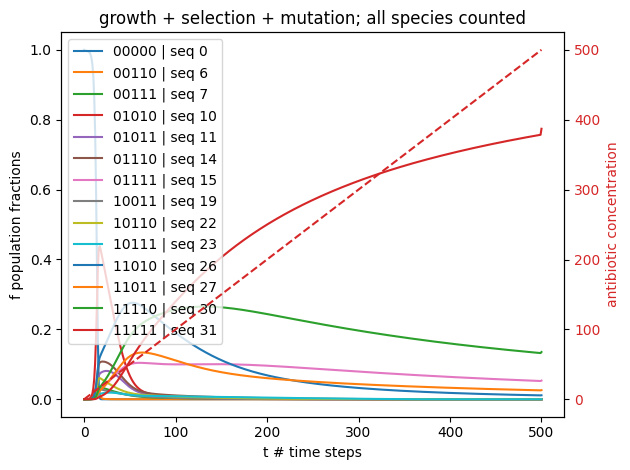

In [352]:
# mutation, growth, selection


c_init = 0.1 # antibiotic conc

seq = np.arange(len(MIC))

mu = get_mu(f_growth(c_init,MIC[seq],g0[seq])) # eqns for all possible species

f = np.zeros(len(mu)) #start with wildtype only
f[0]=1

f=f/np.sum(f)

# time steps 
dt = 1
ff =[f]
cc=[c_init]
c_t = c_init
for i in range(0,500):
    c_t += c_init*10
    mu = get_mu(f_growth(c_t,MIC[seq],g0[seq]))
    
    mu_w = np.sum(f*mu) #avg mu
    
    for j in range(0,len(f)):
        # for each species
        f[j]+=( mu[j]*np.sum(f*Q.T[j]) - mu_w*f[j])*dt
    
    f = f/np.sum(f)

    ff.append(f)
    cc.append(c_t)
        
evol = np.array(ff).T

# plotting
fig, ax1 = plt.subplots()

for count,traj in enumerate(evol):
    if np.sum(traj) > 0.1:
    #plt.plot(traj,'-',c='blue',alpha=0.4*mu[count],ms=3,label=mutations_32[count])
    # ugh colors c='blue',alpha=0.1*(1.1+m.log10(MIC[count]))
        ax1.plot(traj,'-',ms=3,label= mutations_32[seq[count]]+" | seq "+str(seq[count]))

ax1.set_xlabel("t # time steps")
ax1.set_ylabel("f population fractions")
ax1.set_title("growth + selection + mutation; all species counted")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(cc,'--',c=color)
ax2.set_ylabel('antibiotic concentration',c=color)
fig.tight_layout()

fig.savefig("compl-sel.jpg",dpi=300)


In [ ]:
# animation plot

In [207]:
m.log10(10)


0.0

In [ ]:
# notes idk what to tdo with them

# visualize MIC fitness landscape
# how to turn binary code of mut to switch between muts


#### 